In [1]:
import argparse
import json
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import tf
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
import os
import csv
import cv2
from nerf_vision_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Get relative path to the current file
PATH = os.getcwd()
print(PATH)
CONGIG_PATH = os.path.join(PATH, '../json/jackal.json')

#Read the config file as a json
move_base_frame = ""
camera_topic = ""
camere_frame = ""
robot_frame = ""

with open(CONGIG_PATH) as f:
    config_dict = json.load(f)
    camera_topic = config_dict["camera_topic"]
    camera_frame = config_dict["camera_frame"]
    robot_frame = config_dict["robot_frame"]
    move_base_frame = config_dict["move_base_frame"]
print("Camera Topic:", camera_topic)
print("Camera Frame:", camera_frame)
print("Robot Frame:", robot_frame)
print("Move Base Frame:", move_base_frame)

#Read the coordinates file as a csv
COORDINATES_PATH = os.path.join(PATH, '../targets/3_targets.csv')
coordinates = []
with open(COORDINATES_PATH) as f:
    reader = csv.reader(f)
    for row in reader:
        #Convert the string to float
        row = [float(i) for i in row]
        coordinates.append(row)
print(coordinates)

SAVE_PATH = os.path.join(PATH, '../data/3_targets_1')
print("Save Path:", SAVE_PATH)
#Create the save path if it does not exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


/home/boomalope2/nerf_estimator/src/nerf_vision/scripts
Camera Topic: /camera/camera1/image_raw
Camera Frame: camera_link_optical
Robot Frame: base_link
Move Base Frame: world
[[1.0, 1.0, 0.0], [1.0, 1.0, 0.6], [1.0, 1.0, 1.2], [1.0, 1.0, 1.8], [1.0, 1.0, 2.4], [1.0, 1.0, 3.0], [1.0, 1.0, 3.6], [1.0, 1.0, 4.2], [1.0, 1.0, 4.8], [1.0, 1.0, 5.4], [1.0, 1.0, 6.0], [1.0, 3.0, 0.0], [1.0, 3.0, 0.6], [1.0, 3.0, 1.2], [1.0, 3.0, 1.8], [1.0, 3.0, 2.4], [1.0, 3.0, 3.0], [1.0, 3.0, 3.6], [1.0, 3.0, 4.2], [1.0, 3.0, 4.8], [1.0, 3.0, 5.4], [1.0, 3.0, 6.0], [3.0, 3.0, 0.0], [3.0, 3.0, 0.6], [3.0, 3.0, 1.2], [3.0, 3.0, 1.8], [3.0, 3.0, 2.4], [3.0, 3.0, 3.0], [3.0, 3.0, 3.6], [3.0, 3.0, 4.2], [3.0, 3.0, 4.8], [3.0, 3.0, 5.4], [3.0, 3.0, 6.0]]
Save Path: /home/boomalope2/nerf_estimator/src/nerf_vision/scripts/../data/3_targets


In [3]:
rospy.init_node('data_collection')

#Initialize the odom injector
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()

current_camera_img = None
#Initialize the camera subscriber
def callback(data):
    global current_camera_img
    cv_image = getCameraTopicAsCvImage(data)
    #Convert the image to BGR
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR)
    current_camera_img = cv_image
# Subscribe to the camera topic
rospy.Subscriber(camera_topic, Image, callback)

Going to:  [1.0, 1.0, 0.0]


[ERROR] [1698229508.610961, 18.024000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 1.0, 0.0]
xyz:  [1.2010056804353426, -1.2816034802705236, -1.5471350799107766]
rpy:  (-0.7395789908032369, -0.29438682068951744, -0.30823154397337393)


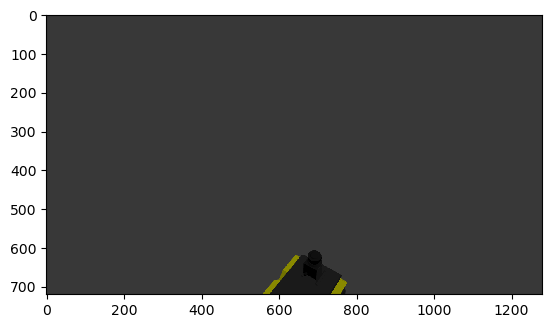

Going to:  [1.0, 1.0, 0.6]
Reached:  [1.0, 1.0, 0.6]
xyz:  [1.201398643055578, -1.2816709346764574, -1.5470677261009733]
rpy:  (-0.7848162686884324, -0.03932723925111152, -0.0393939780400749)


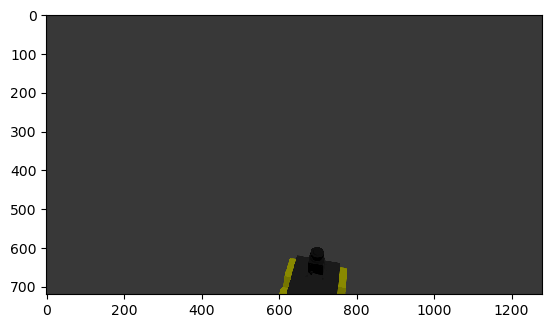

Going to:  [1.0, 1.0, 1.2]
Reached:  [1.0, 1.0, 1.2]
xyz:  [1.201798401712261, -1.2816416953726437, -1.547097066672281]
rpy:  (-0.706428667684407, 0.3782488905797106, 0.40847823957790635)


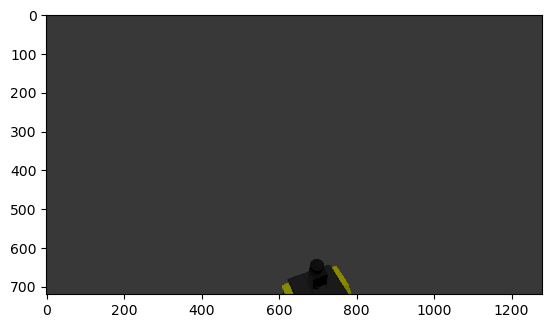

Going to:  [1.0, 1.0, 1.8]
Reached:  [1.0, 1.0, 1.8]
xyz:  [1.2015966190750131, -1.2816096594119841, -1.547129083834748]
rpy:  (-0.35864750929567374, 0.7152425202189298, 1.0517350024486132)


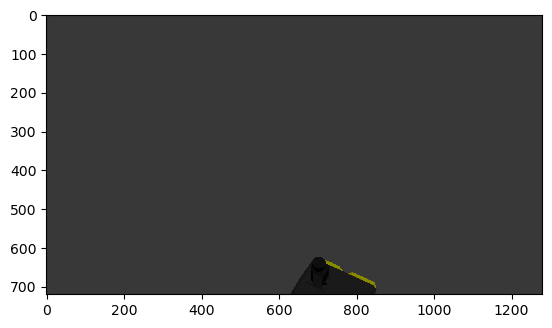

Going to:  [1.0, 1.0, 2.4]
Reached:  [1.0, 1.0, 2.4]
xyz:  [1.2014987637587171, -1.281589345236765, -1.5471494026269903]
rpy:  (0.17427307059025562, 0.7699516687969855, 1.8188173800132912)


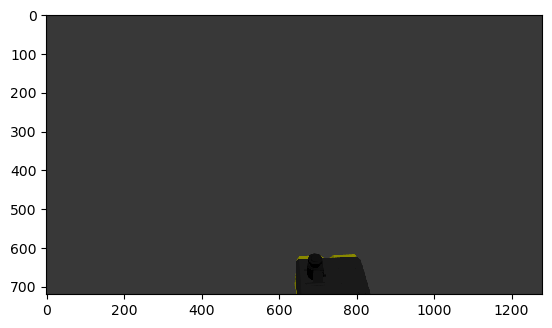

Going to:  [1.0, 1.0, 3.0]
Reached:  [1.0, 1.0, 3.0]
xyz:  [1.201451322852388, -1.2816385897109253, -1.5471001605107553]
rpy:  (0.6138119719536635, 0.5257059136593574, 2.5232382882678475)


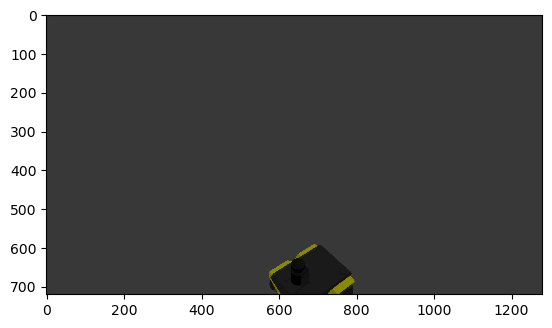

Going to:  [1.0, 1.0, 3.6]


[ERROR] [1698229719.410440, 52.349000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 1.0, 3.6]
xyz:  [1.200992128543313, -1.2813657737816617, -1.5473731115430551]
rpy:  (0.7746117264598302, 0.14432407574102338, 2.995974461796699)


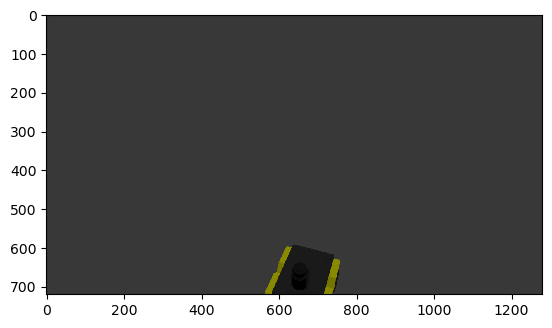

Going to:  [1.0, 1.0, 4.2]
Reached:  [1.0, 1.0, 4.2]
xyz:  [1.2003336654213659, -1.2813333542510492, -1.5474056757100234]
rpy:  (0.7455236614649087, -0.2740120933226921, -2.8564968324561546)


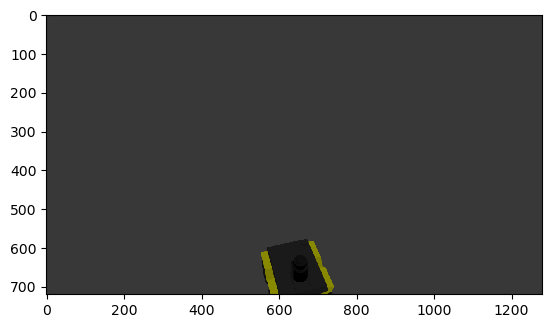

Going to:  [1.0, 1.0, 4.8]
Reached:  [1.0, 1.0, 4.8]
xyz:  [1.200455681999389, -1.281332822666942, -1.5474061938118095]
rpy:  (0.4866107077805414, -0.6432435574880676, -2.293858028196259)


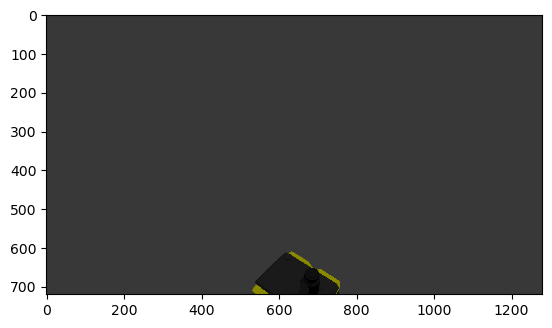

Going to:  [1.0, 1.0, 5.4]
Reached:  [1.0, 1.0, 5.4]
xyz:  [1.2001606279315025, -1.2818790150056105, -1.546860176141776]
rpy:  (-0.0322132374002503, -0.7849295889987136, -1.5255714439471815)


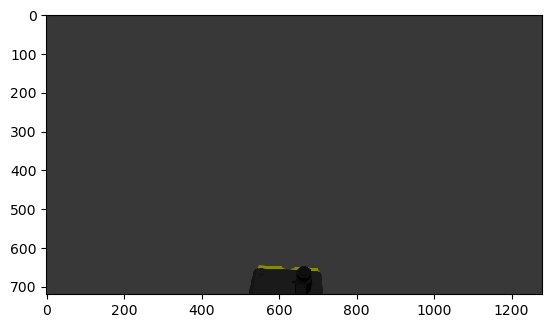

Going to:  [1.0, 1.0, 6.0]
Reached:  [1.0, 1.0, 6.0]
xyz:  [1.2002642591052022, -1.281847244342242, -1.5468919441663127]
rpy:  (-0.5519216106849514, -0.5913033408873716, -0.7360499342831348)


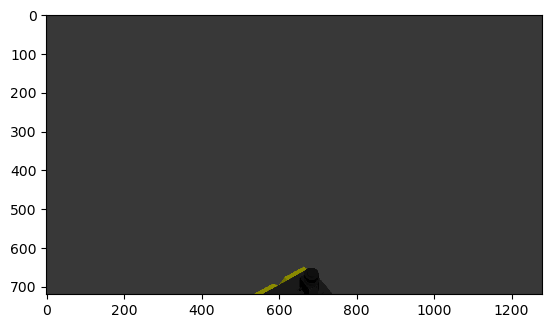

Going to:  [1.0, 3.0, 0.0]
Reached:  [1.0, 3.0, 0.0]
xyz:  [2.3481183538402908, -0.09297694244932764, -2.7362408595859304]
rpy:  (-0.7472212402167372, -0.26991896449207914, -0.28037237699657197)


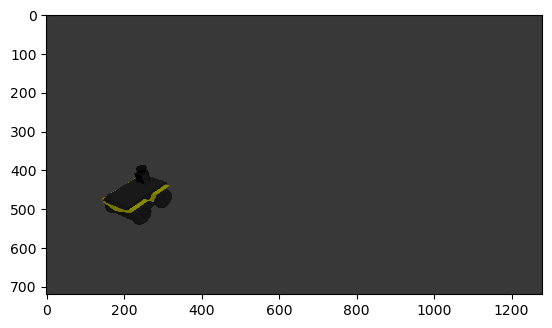

Going to:  [1.0, 3.0, 0.6]
Reached:  [1.0, 3.0, 0.6]
xyz:  [2.34748524799049, -0.09280927048431997, -2.736408407686656]
rpy:  (-0.7846408436692693, -0.04390469226315433, -0.04408220073066943)


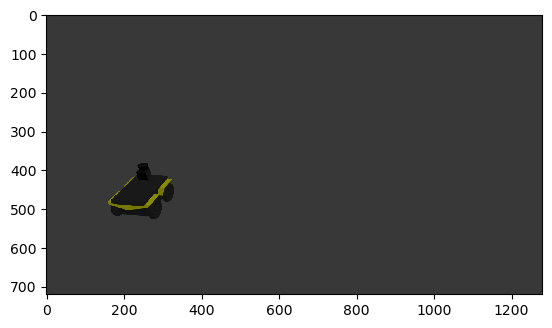

Going to:  [1.0, 3.0, 1.2]
Reached:  [1.0, 3.0, 1.2]
xyz:  [2.3473405070557916, -0.09293357331540286, -2.736284075850814]
rpy:  (-0.7056840711964694, 0.3800148113066208, 0.4106921638355603)


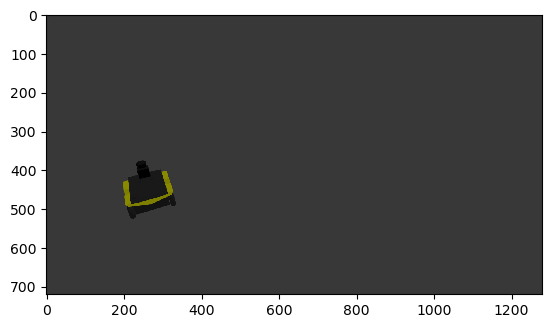

Going to:  [1.0, 3.0, 1.8]


[ERROR] [1698229972.911585, 95.605000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 3.0, 1.8]
xyz:  [2.347713530562476, -0.09269482211784852, -2.7365229265562903]
rpy:  (-0.406931438875227, 0.6922759256711882, 0.97705129869414)


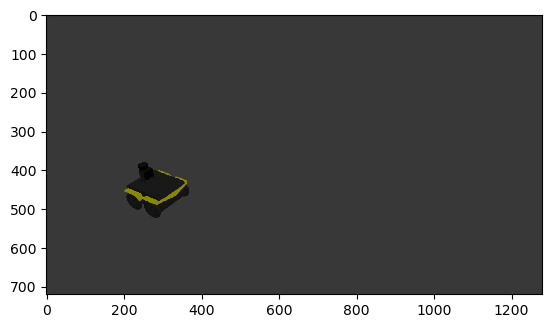

Going to:  [1.0, 3.0, 2.4]
Reached:  [1.0, 3.0, 2.4]
xyz:  [2.3475625378883103, -0.09295869919557931, -2.736258978401551]
rpy:  (0.1773181062131206, 0.7695253232447764, 1.8231893311479104)


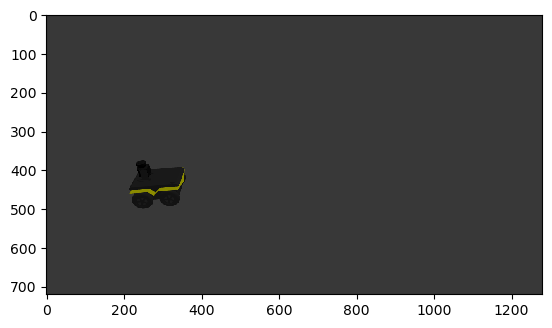

Going to:  [1.0, 3.0, 3.0]
Reached:  [1.0, 3.0, 3.0]
xyz:  [2.3477528522570936, -0.09342305691266728, -2.7357945014902505]
rpy:  (0.6049149854120222, 0.5359807886740844, 2.5058503106578978)


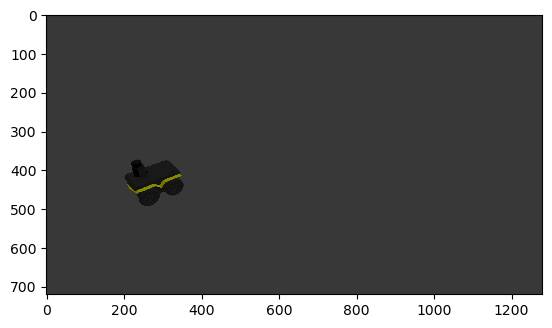

Going to:  [1.0, 3.0, 3.6]
Reached:  [1.0, 3.0, 3.6]
xyz:  [2.3483639558103446, -0.09374694868232614, -2.73547047994065]
rpy:  (0.7754509293972545, 0.13787826340951925, 3.002202098893351)


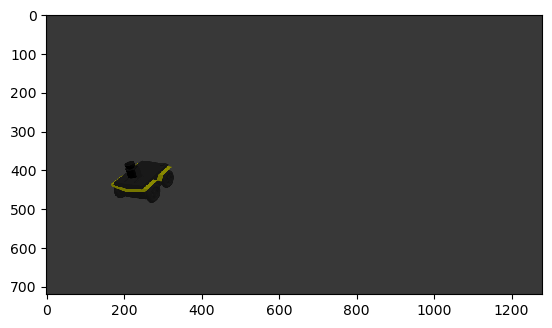

Going to:  [1.0, 3.0, 4.2]
Reached:  [1.0, 3.0, 4.2]
xyz:  [2.349163477700115, -0.09377271550666766, -2.7354445778976872]
rpy:  (0.7416569513882124, -0.2868439332153562, -2.8420268810341645)


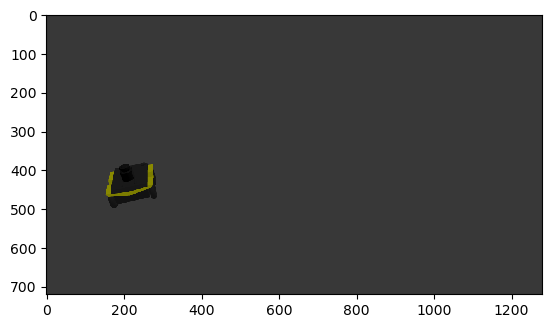

Going to:  [1.0, 3.0, 4.8]


[ERROR] [1698230113.939932, 118.329000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 3.0, 4.8]
xyz:  [2.349836769548617, -0.09331909617855594, -2.735898043326743]
rpy:  (0.51050976508024, -0.6257392972837178, -2.3338688153708422)


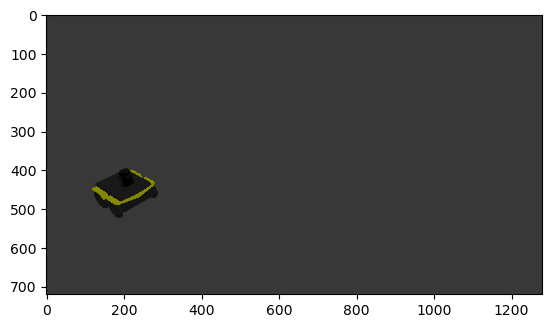

Going to:  [1.0, 3.0, 5.4]


[ERROR] [1698230146.728287, 123.930000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 3.0, 5.4]
xyz:  [2.3501436319839684, -0.09295591258427494, -2.736261139422546]
rpy:  (-0.07092146958891885, -0.7827739023987853, -1.4708741868051165)


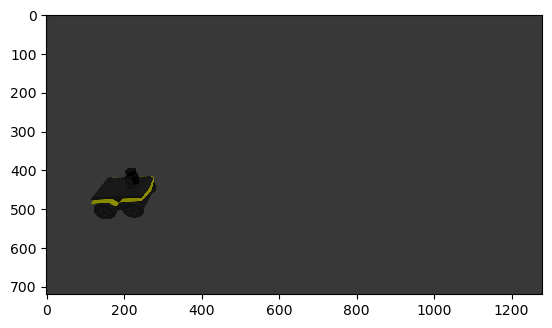

Going to:  [1.0, 3.0, 6.0]


[ERROR] [1698230169.911777, 127.838000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [1.0, 3.0, 6.0]
xyz:  [2.3499694797339403, -0.09271770552455139, -2.7364992924297855]
rpy:  (-0.5473884853880141, -0.5952661171328999, -0.7440136772064773)


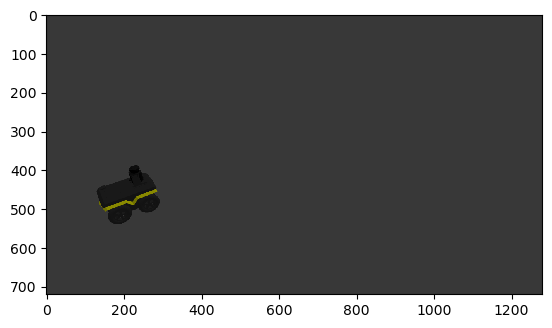

Going to:  [3.0, 3.0, 0.0]
Reached:  [3.0, 3.0, 0.0]
xyz:  [3.8760688793419042, -0.6045926644497791, -2.224900438278649]
rpy:  (-0.74535971706472, -0.2763667593882558, -0.2876964616750395)


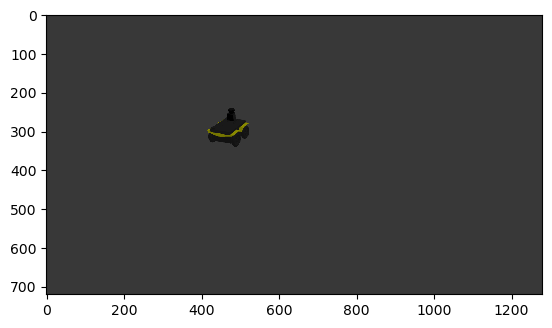

Going to:  [3.0, 3.0, 0.6]
Reached:  [3.0, 3.0, 0.6]
xyz:  [3.8765524514663277, -0.6047110965969366, -2.224782072080992]
rpy:  (-0.7853707328774321, -0.019582336983326724, -0.01961814704707952)


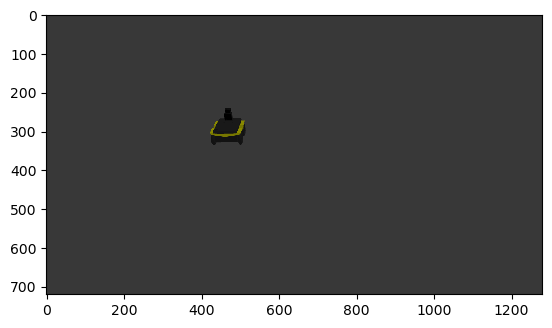

Going to:  [3.0, 3.0, 1.2]
Reached:  [3.0, 3.0, 1.2]
xyz:  [3.8773695584661025, -0.6046422436003208, -2.2248510559136845]
rpy:  (-0.7051218767947244, 0.3812213323677004, 0.41221602739242513)


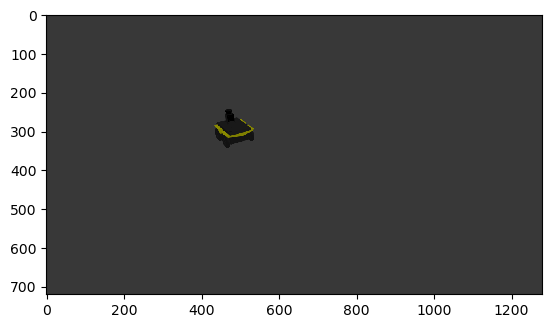

Going to:  [3.0, 3.0, 1.8]
Reached:  [3.0, 3.0, 1.8]
xyz:  [3.87734882604893, -0.60450418760756, -2.2249891342655252]
rpy:  (-0.3949488010935067, 0.6985232782625177, 0.9956415236011416)


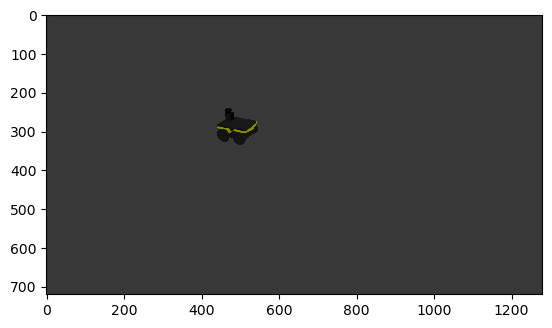

Going to:  [3.0, 3.0, 2.4]
Reached:  [3.0, 3.0, 2.4]
xyz:  [3.8772663534338845, -0.604795895653415, -2.2246973545443134]
rpy:  (0.14732769299655762, 0.7745536610883826, 1.7803438113380692)


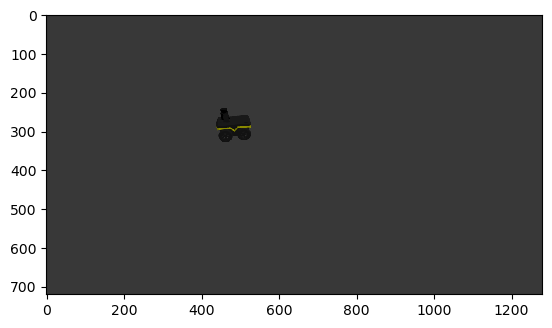

Going to:  [3.0, 3.0, 3.0]


[ERROR] [1698230333.705626, 157.878000]: Got a transition callback on a goal handle that we're not tracking


Reached:  [3.0, 3.0, 3.0]
xyz:  [3.8771633533929615, -0.6047244056129123, -2.2247688690298784]
rpy:  (0.6226874304531584, 0.5142097822945624, 2.541271095719621)


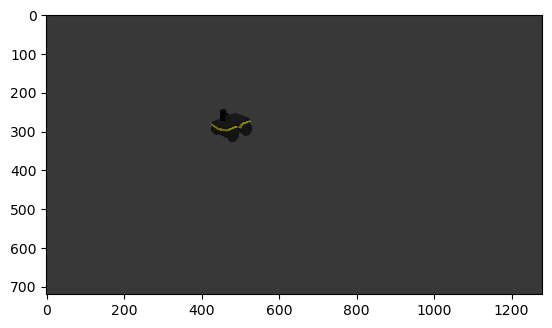

Going to:  [3.0, 3.0, 3.6]
Reached:  [3.0, 3.0, 3.6]
xyz:  [3.8767869926622027, -0.6044904954506347, -2.2250028612111974]
rpy:  (0.7780965343302949, 0.118035913540366, 3.022801306914759)


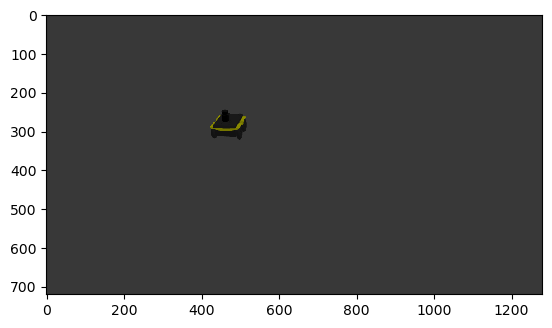

Going to:  [3.0, 3.0, 4.2]
Reached:  [3.0, 3.0, 4.2]
xyz:  [3.8760154369054667, -0.6044936691762944, -2.2249998088805887]
rpy:  (0.7445389136263545, -0.2773367578969085, -2.8529373815587147)


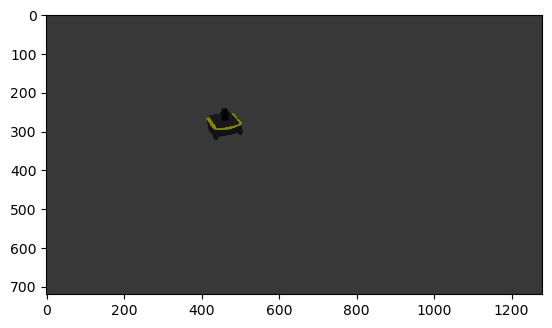

Going to:  [3.0, 3.0, 4.8]
Reached:  [3.0, 3.0, 4.8]
xyz:  [3.875939863474527, -0.6046760656599267, -2.2248174480043676]
rpy:  (0.48964848114545956, -0.6412934145180195, -2.29904544382)


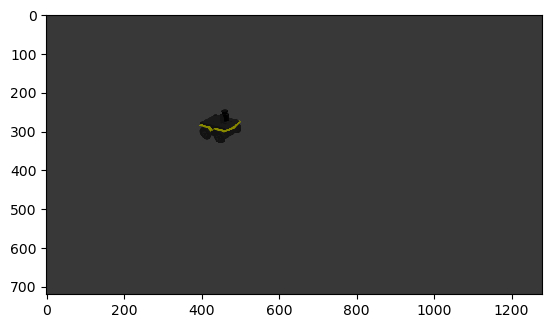

Going to:  [3.0, 3.0, 5.4]
Reached:  [3.0, 3.0, 5.4]
xyz:  [3.876091954379181, -0.604366016220095, -2.2251274296600294]
rpy:  (-0.01768885509378647, -0.7854031750196598, -1.5460281158816795)


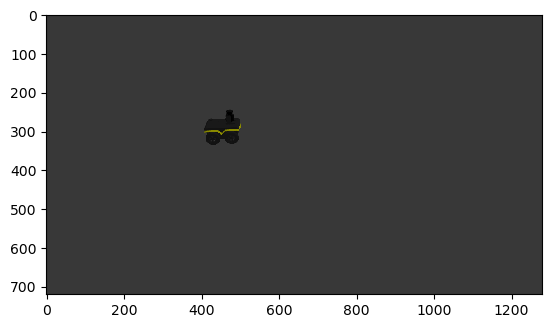

Going to:  [3.0, 3.0, 6.0]
Reached:  [3.0, 3.0, 6.0]
xyz:  [3.876222607073375, -0.6044977774677393, -2.2249957017377673]
rpy:  (-0.5482566290317255, -0.5944527663991772, -0.7421766749788997)


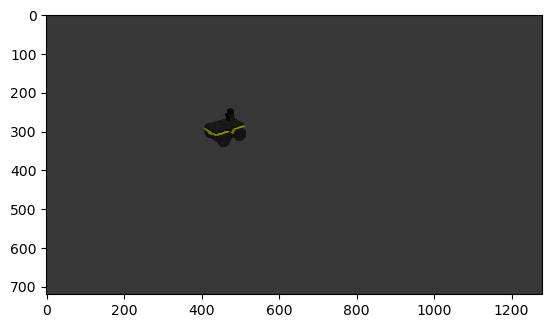

In [4]:
#Iterate through coordiates, capturing a picture and pose once arriving at each coordinate
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()
for i, c in enumerate(coordinates):
    print("Going to: ", c)
    
    #Navigate to goal
    goal = getMoveBaseGoal(move_base_frame, c[0], c[1], c[2])
    client.send_goal(goal)
    client.wait_for_result()
    print("Reached: ", c)

    #Calculate relative pose
    xyz, rpy = getRobotPose(camera_frame, robot_frame)
    print("xyz: ", xyz)
    print("rpy: ", rpy)

    #Capture image
    plt.imshow(current_camera_img)
    plt.show()

    #Save image and pose
    img_name = str(i) + '.png'
    pose_name = str(i) + '.txt'
    img_path = os.path.join(SAVE_PATH, img_name)
    pose_path = os.path.join(SAVE_PATH, pose_name)
    cv2.imwrite(img_path, current_camera_img)
    with open(pose_path, 'w') as f:
        xyz = str(xyz[0]+', '+xyz[1]+', '+xyz[2])
        rpy = str(rpy[0]+', '+rpy[1]+', '+rpy[2])
        goal = str(c[0]+', '+c[1]+', '+c[2])
        f.write(xyz+', '+rpy+', '+goal)